In [5]:
import torch
from torch import nn
from torchvision.transforms import v2
import segmentation_models_pytorch as smp
import cv2
import numpy as np
from torch.utils.data import DataLoader
from catalyst import dl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
import sys
import os
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "datasets"))

from InriaImagesDataset import ImagesDataset


In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_DIR = os.path.join(os.path.abspath('..'), 'data', 'PreprocessedAerialImageDataset', 'train')

# Загрузка данных

In [11]:
df_all = pd.read_csv(os.path.join(DATA_DIR, 'labels.csv'))
df_all.head(10)

,images_paths,images_names,masks_paths,masks_names
0,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
1,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
2,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
3,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
4,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
5,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
6,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
7,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
8,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10
9,D:/housing-segmentation-in-amur-river-area/dat...,austin10,D:/housing-segmentation-in-amur-river-area/dat...,austin10


In [13]:
X, y = df_all[['images_paths']], df_all['masks_paths']

In [15]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, shuffle=True)

In [16]:
df_train, df_val, df_test = pd.concat([X_train, y_train], axis=1), pd.concat([X_val, y_val], axis=1), pd.concat([X_test, y_test], axis=1)

In [18]:
transforms = v2.Compose([
    v2.Resize(size=(512, 512)),
])

In [19]:
ds_train = ImagesDataset(df_train, DATA_DIR, img_transform=transforms, mask_transform=transforms)
ds_val = ImagesDataset(df_val, DATA_DIR, img_transform=transforms, mask_transform=transforms)
ds_test = ImagesDataset(df_test, DATA_DIR)

In [20]:
loaders = {"train": DataLoader(ds_train, batch_size=8), 'valid': DataLoader(ds_val, batch_size=32)}

# Подготовка к обучению модели

In [23]:
model = smp.Unet(encoder_name='efficientnet-b0', activation='sigmoid').to(DEVICE)

In [24]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [25]:
criterion = {"loss": nn.BCELoss()}

In [13]:
optimizer = {
    "classification": torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999)),
}

In [14]:
class CustomRunner(dl.SupervisedRunner):
    def handle_batch(self, batch):
        image, mask, label = batch['image'], batch['mask'], batch['label']
        mask_pred, label_pred = self.model(image)
        
        self.batch = {self._input_key: image, self._output_key: label_pred, self._target_key: label}

In [15]:
runner = CustomRunner(input_key="image", output_key="preds_out", target_key="label", loss_key="loss")

# Обучение модели

In [17]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    engine=dl.GPUEngine("cuda:0"),
    loaders=loaders,
    callbacks=[
        dl.CriterionCallback(
            input_key="preds_out",
            target_key="label",
            metric_key="loss",
            criterion_key="loss",
        ),
        dl.BackwardCallback(metric_key="loss"),
        dl.OptimizerCallback(
            optimizer_key="classification",
            metric_key="loss",
        ),
        dl.AUCCallback(input_key="preds_out", target_key="label"),
    ],
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    num_epochs=20,
    verbose=True,
    logdir="./logs",
    load_best_on_end=True
)

1/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (1/20) auc: 0.7280555367469788 | auc/_macro: 0.7280555367469788 | auc/_micro: 0.7280555555555555 | auc/_weighted: 0.3640277683734894 | loss: 0.9141716890037059 | loss/mean: 0.9141716890037059 | loss/std: 0.6283771483925027 | lr/classification: 0.001 | momentum/classification: 0.5


c:\Users\MZ\Documents\python-projects\quizgroup-test\env\lib\site-packages\accelerate\utils\dataclasses.py:480: FutureWarning: The `TPU` of `<enum 'DistributedType'>` is deprecated and will be removed in v1.0.0. Please use the `XLA` instead.
  warnings.warn(


1/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (1/20) auc: 0.5824999809265137 | auc/_macro: 0.5824999809265137 | auc/_micro: 0.5825 | auc/_weighted: 0.29124999046325684 | loss: 2.959755778312683 | loss/mean: 2.959755778312683 | loss/std: 0.7541273214777539 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (1/20) 


2/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (2/20) auc: 0.961388885974884 | auc/_macro: 0.961388885974884 | auc/_micro: 0.9613888888888888 | auc/_weighted: 0.480694442987442 | loss: 0.25572291019683085 | loss/mean: 0.25572291019683085 | loss/std: 0.31810508851195496 | lr/classification: 0.001 | momentum/classification: 0.5


2/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (2/20) auc: 0.5475000143051147 | auc/_macro: 0.5475000143051147 | auc/_micro: 0.5475 | auc/_weighted: 0.2737500071525574 | loss: 1.2496885061264038 | loss/mean: 1.2496885061264038 | loss/std: 0.20146909683204695 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (2/20) 


3/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (3/20) auc: 0.9950000047683716 | auc/_macro: 0.9950000047683716 | auc/_micro: 0.9949999999999999 | auc/_weighted: 0.4975000023841858 | loss: 0.10904153715819119 | loss/mean: 0.10904153715819119 | loss/std: 0.15694392357231157 | lr/classification: 0.001 | momentum/classification: 0.5


3/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (3/20) auc: 0.6974999904632568 | auc/_macro: 0.6974999904632568 | auc/_micro: 0.6975000000000001 | auc/_weighted: 0.3487499952316284 | loss: 1.283376121520996 | loss/mean: 1.283376121520996 | loss/std: 0.39321181957849166 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (3/20) 


4/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (4/20) auc: 0.9819444417953491 | auc/_macro: 0.9819444417953491 | auc/_micro: 0.9819444444444443 | auc/_weighted: 0.49097222089767456 | loss: 0.16170729612931614 | loss/mean: 0.16170729612931614 | loss/std: 0.37081174581996934 | lr/classification: 0.001 | momentum/classification: 0.5


4/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (4/20) auc: 0.8025000095367432 | auc/_macro: 0.8025000095367432 | auc/_micro: 0.8025 | auc/_weighted: 0.4012500047683716 | loss: 0.7040764093399048 | loss/mean: 0.7040764093399048 | loss/std: 0.030336275420433233 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (4/20) 


5/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (5/20) auc: 0.9958333373069763 | auc/_macro: 0.9958333373069763 | auc/_micro: 0.9958333333333333 | auc/_weighted: 0.49791666865348816 | loss: 0.07330163329606877 | loss/mean: 0.07330163329606877 | loss/std: 0.11051078669898644 | lr/classification: 0.001 | momentum/classification: 0.5


5/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (5/20) auc: 0.8125 | auc/_macro: 0.8125 | auc/_micro: 0.8125 | auc/_weighted: 0.40625 | loss: 0.7858512759208679 | loss/mean: 0.7858512759208679 | loss/std: 0.20632059741021247 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (5/20) 


6/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (6/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.03154935483665516 | loss/mean: 0.03154935483665516 | loss/std: 0.03293470349239004 | lr/classification: 0.001 | momentum/classification: 0.5


6/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (6/20) auc: 0.75 | auc/_macro: 0.75 | auc/_micro: 0.75 | auc/_weighted: 0.375 | loss: 1.1464368641376494 | loss/mean: 1.1464368641376494 | loss/std: 0.42011163453798156 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (6/20) 


7/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (7/20) auc: 0.9952777624130249 | auc/_macro: 0.9952777624130249 | auc/_micro: 0.9952777777777777 | auc/_weighted: 0.49763888120651245 | loss: 0.09739608428111143 | loss/mean: 0.09739608428111143 | loss/std: 0.20850886907943225 | lr/classification: 0.001 | momentum/classification: 0.5


7/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (7/20) auc: 0.8025000095367432 | auc/_macro: 0.8025000095367432 | auc/_micro: 0.8024999999999999 | auc/_weighted: 0.4012500047683716 | loss: 0.9034760236740113 | loss/mean: 0.9034760236740113 | loss/std: 0.1544076071622353 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (7/20) 


8/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (8/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.008544559061313824 | loss/mean: 0.008544559061313824 | loss/std: 0.013431210552472221 | lr/classification: 0.001 | momentum/classification: 0.5


8/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (8/20) auc: 0.8075000047683716 | auc/_macro: 0.8075000047683716 | auc/_micro: 0.8075 | auc/_weighted: 0.4037500023841858 | loss: 0.9147773742675781 | loss/mean: 0.9147773742675781 | loss/std: 0.26004851493256487 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (8/20) 


9/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (9/20) auc: 0.9997222423553467 | auc/_macro: 0.9997222423553467 | auc/_micro: 0.9997222222222222 | auc/_weighted: 0.49986112117767334 | loss: 0.022485377268943313 | loss/mean: 0.022485377268943313 | loss/std: 0.05246502462613785 | lr/classification: 0.001 | momentum/classification: 0.5


9/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (9/20) auc: 0.7825000286102295 | auc/_macro: 0.7825000286102295 | auc/_micro: 0.7825000000000001 | auc/_weighted: 0.39125001430511475 | loss: 0.9629172444343567 | loss/mean: 0.9629172444343567 | loss/std: 0.22237620621067813 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (9/20) 


10/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (10/20) auc: 0.9994444251060486 | auc/_macro: 0.9994444251060486 | auc/_micro: 0.9994444444444444 | auc/_weighted: 0.4997222125530243 | loss: 0.032156350673418876 | loss/mean: 0.032156350673418876 | loss/std: 0.06637838127896888 | lr/classification: 0.001 | momentum/classification: 0.5


10/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (10/20) auc: 0.7524999976158142 | auc/_macro: 0.7524999976158142 | auc/_micro: 0.7525 | auc/_weighted: 0.3762499988079071 | loss: 1.2482067942619324 | loss/mean: 1.2482067942619324 | loss/std: 0.3835508558910254 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (10/20) 


11/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (11/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.017983242928676188 | loss/mean: 0.017983242928676188 | loss/std: 0.030433716646098813 | lr/classification: 0.001 | momentum/classification: 0.5


11/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (11/20) auc: 0.7574999928474426 | auc/_macro: 0.7574999928474426 | auc/_micro: 0.7575 | auc/_weighted: 0.3787499964237213 | loss: 1.1032963156700135 | loss/mean: 1.1032963156700135 | loss/std: 0.265687596303051 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (11/20) 


12/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (12/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0042486554924228885 | loss/mean: 0.0042486554924228885 | loss/std: 0.010255426612576127 | lr/classification: 0.001 | momentum/classification: 0.5


12/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (12/20) auc: 0.7674999833106995 | auc/_macro: 0.7674999833106995 | auc/_micro: 0.7675000000000001 | auc/_weighted: 0.38374999165534973 | loss: 0.9751977443695068 | loss/mean: 0.9751977443695068 | loss/std: 0.22870469241231084 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (12/20) 


13/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (13/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0009633074650385728 | loss/mean: 0.0009633074650385728 | loss/std: 0.0010355959901559907 | lr/classification: 0.001 | momentum/classification: 0.5


13/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (13/20) auc: 0.7900000214576721 | auc/_macro: 0.7900000214576721 | auc/_micro: 0.7899999999999999 | auc/_weighted: 0.39500001072883606 | loss: 0.9502658009529114 | loss/mean: 0.9502658009529114 | loss/std: 0.2194005039344628 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (13/20) 


14/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (14/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0006902626865970281 | loss/mean: 0.0006902626865970281 | loss/std: 0.0007462955998097651 | lr/classification: 0.001 | momentum/classification: 0.5


14/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (14/20) auc: 0.800000011920929 | auc/_macro: 0.800000011920929 | auc/_micro: 0.8 | auc/_weighted: 0.4000000059604645 | loss: 0.9267668962478638 | loss/mean: 0.9267668962478638 | loss/std: 0.22733959744405288 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (14/20) 


15/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (15/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0014257281717921916 | loss/mean: 0.0014257281717921916 | loss/std: 0.0019124549270864524 | lr/classification: 0.001 | momentum/classification: 0.5


15/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (15/20) auc: 0.7875000238418579 | auc/_macro: 0.7875000238418579 | auc/_micro: 0.7875 | auc/_weighted: 0.39375001192092896 | loss: 0.9044249176979064 | loss/mean: 0.9044249176979064 | loss/std: 0.22595680375972493 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (15/20) 


16/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (16/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0009754810282174729 | loss/mean: 0.0009754810282174729 | loss/std: 0.0012694720681970442 | lr/classification: 0.001 | momentum/classification: 0.5


16/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (16/20) auc: 0.7850000262260437 | auc/_macro: 0.7850000262260437 | auc/_micro: 0.785 | auc/_weighted: 0.39250001311302185 | loss: 0.9194631695747375 | loss/mean: 0.9194631695747375 | loss/std: 0.2330022449085149 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (16/20) 


17/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (17/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0004851188472609162 | loss/mean: 0.0004851188472609162 | loss/std: 0.0005757526897043063 | lr/classification: 0.001 | momentum/classification: 0.5


17/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (17/20) auc: 0.7875000238418579 | auc/_macro: 0.7875000238418579 | auc/_micro: 0.7875 | auc/_weighted: 0.39375001192092896 | loss: 0.9163650691509246 | loss/mean: 0.9163650691509246 | loss/std: 0.23408994328800053 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (17/20) 


18/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (18/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0003194358983212927 | loss/mean: 0.0003194358983212927 | loss/std: 0.00037254281707451407 | lr/classification: 0.001 | momentum/classification: 0.5


18/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (18/20) auc: 0.7875000238418579 | auc/_macro: 0.7875000238418579 | auc/_micro: 0.7875 | auc/_weighted: 0.39375001192092896 | loss: 0.90727778673172 | loss/mean: 0.90727778673172 | loss/std: 0.2354137613734186 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (18/20) 


19/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (19/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.0002650139442872993 | loss/mean: 0.0002650139442872993 | loss/std: 0.0002073472735315512 | lr/classification: 0.001 | momentum/classification: 0.5


19/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (19/20) auc: 0.7925000190734863 | auc/_macro: 0.7925000190734863 | auc/_micro: 0.7925000000000001 | auc/_weighted: 0.39625000953674316 | loss: 0.9015114605426788 | loss/mean: 0.9015114605426788 | loss/std: 0.2335978803483138 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (19/20) 


20/20 * Epoch (train):   0%|          | 0/15 [00:00<?, ?it/s]

train (20/20) auc: 1.0 | auc/_macro: 1.0 | auc/_micro: 1.0 | auc/_weighted: 0.5 | loss: 0.00022610539047794495 | loss/mean: 0.00022610539047794495 | loss/std: 0.0003121831195530342 | lr/classification: 0.001 | momentum/classification: 0.5


20/20 * Epoch (valid):   0%|          | 0/2 [00:00<?, ?it/s]

valid (20/20) auc: 0.7875000238418579 | auc/_macro: 0.7875000238418579 | auc/_micro: 0.7875 | auc/_weighted: 0.39375001192092896 | loss: 0.9056784510612488 | loss/mean: 0.9056784510612488 | loss/std: 0.23062066897284283 | lr/classification: 0.001 | momentum/classification: 0.5
* Epoch (20/20) 
Top models:
./logs\checkpoints/model.0004.pth	0.7041


c:\Users\MZ\Documents\python-projects\quizgroup-test\env\lib\site-packages\catalyst\utils\torch.py:369: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load

# Тестирование модели

In [18]:
def inference_one_image(image, model):
    image_tensor = cv2.resize(image, (512, 512)).astype(np.float32)
    image_tensor = torch.tensor(image_tensor, device=DEVICE).permute(2, 0, 1).unsqueeze(0)
    model.eval()
    result_mask, result_label = model(image_tensor)
    result_mask = result_mask.sigmoid().squeeze().detach().cpu().numpy()
    #result_mask = (result_mask > 0.5).astype(np.int_)
    result_label = result_label.squeeze().detach().cpu().numpy()
    return result_mask, result_label

In [19]:
transform_test = v2.Resize((512, 512))

In [20]:
torch.cuda.empty_cache()
preds_test = []
preds_probas = []
labels_test = []
model.eval()
for elem in ds_test:
    image, label = transform_test(elem['image']).to(DEVICE).unsqueeze(0), int(elem['label'].item())
    #print(image, label)
    mask, pred = model(image)
    mask = mask.sigmoid()
    pred = pred.sigmoid()
    preds_probas.append(pred.item())
    pred = 1 if pred.item() > 0.5 else 0
    preds_test.append(pred)
    labels_test.append(label)

In [21]:
labels_test.count(1)/len(labels_test)

0.5

In [22]:
accuracy_score(labels_test, preds_test)

0.5

In [23]:
recall_score(labels_test, preds_test)

1.0

In [24]:
precision_score(labels_test, preds_test)

0.5

In [25]:
precision, recall, thresholds = precision_recall_curve(labels_test, preds_probas)
precision, recall, thresholds

(array([0.5       , 0.51282051, 0.52631579, 0.54054054, 0.55555556,
        0.54285714, 0.55882353, 0.57575758, 0.59375   , 0.58064516,
        0.56666667, 0.5862069 , 0.60714286, 0.62962963, 0.65384615,
        0.68      , 0.66666667, 0.69565217, 0.72727273, 0.71428571,
        0.7       , 0.68421053, 0.66666667, 0.70588235, 0.75      ,
        0.8       , 0.78571429, 0.84615385, 0.91666667, 0.90909091,
        0.9       , 0.88888889, 0.875     , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]),
 array([1.  , 1.  , 1.  , 1.  , 1.  , 0.95, 0.95, 0.95, 0.95, 0.9 , 0.85,
        0.85, 0.85, 0.85, 0.85, 0.85, 0.8 , 0.8 , 0.8 , 0.75, 0.7 , 0.65,
        0.6 , 0.6 , 0.6 , 0.6 , 0.55, 0.55, 0.55, 0.5 , 0.45, 0.4 , 0.35,
        0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05, 0.  ]),
 array([0.50000006, 0.50002629, 0.50009549, 0.50031215, 0.50136071,
        0.50246811, 0.50255185, 0.50264156, 0.50876015, 0.50917143,
        0.51090205

Text(0, 0.5, 'Precision')

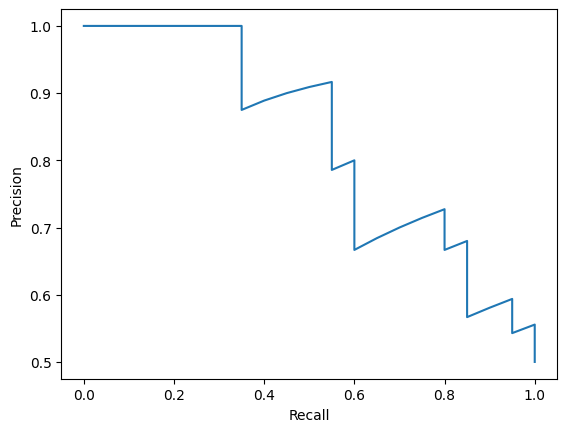

In [26]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [27]:
optimal_proba_cutoff = sorted(list(zip(np.abs(precision - recall), thresholds)), key=lambda i: i[0], reverse=False)[0][1]
optimal_proba_cutoff

0.6732630133628845

In [28]:
torch.cuda.empty_cache()
preds_test = []
preds_probas = []
labels_test = []
model.eval()
for elem in ds_test:
    image, label = transform_test(elem['image']).to(DEVICE).unsqueeze(0), int(elem['label'].item())
    #print(image, label)
    mask, pred = model(image)
    mask = mask.sigmoid()
    pred = pred.sigmoid()
    preds_probas.append(pred.item())
    pred = 1 if pred.item() > optimal_proba_cutoff else 0
    preds_test.append(pred)
    labels_test.append(label)

## Анализ метрик

In [29]:
accuracy_score(labels_test, preds_test)

0.675

In [30]:
recall_score(labels_test, preds_test)

0.65

In [31]:
precision_score(labels_test, preds_test)

0.6842105263157895

При пороге принятия решения, равном 0.5, наблюдается очень большой разброс метрик - это означает, что такое значение порога плохо разделяет два класса.

После подбора порога разброс метрик выровнялся - но при этом, их значения невысоки. Это означает, что для модели мало одной функции потерь (только для результатов классификации). Необходимо обучать модель также в контексте сегментации.

In [32]:
test_image = cv2.imread('./data/images/000000019499.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

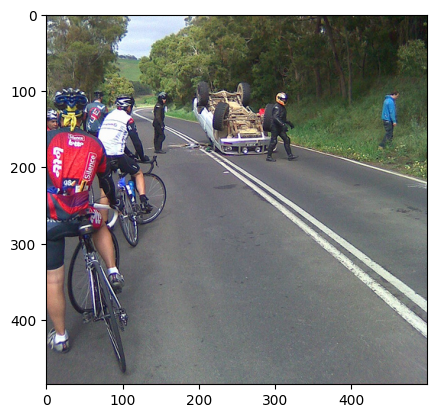

In [33]:
plt.imshow(test_image)

In [34]:
test_image = cv2.imread('./data/images/000000019499.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

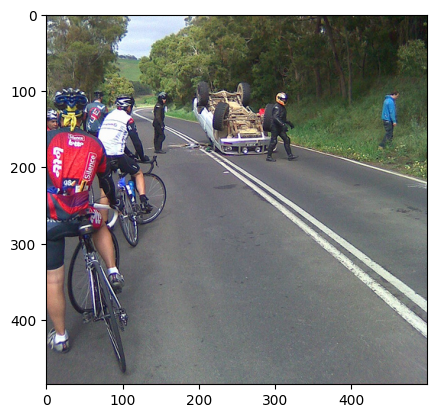

In [35]:
plt.imshow(test_image)

In [36]:
test_image_mask = cv2.imread('./data/masks/000000019499.png')
test_image_mask = cv2.cvtColor(test_image_mask, cv2.COLOR_BGR2GRAY)

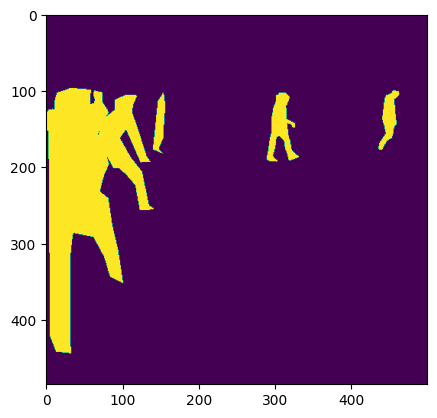

In [37]:
plt.imshow(test_image_mask)

In [38]:
mask, label = inference_one_image(test_image, model)
print(1 if label > 0.5 else 0)

1


In [39]:
test_image = cv2.imread('./data/images/000000002759.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

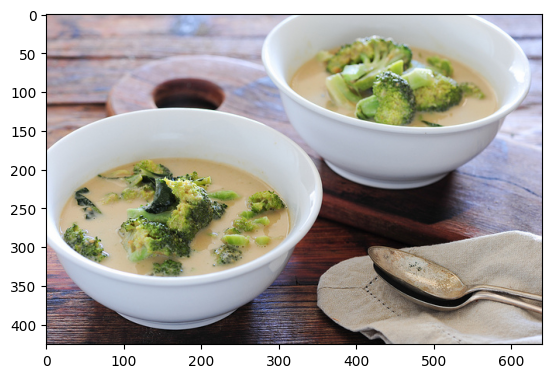

In [40]:
plt.imshow(test_image)

In [41]:
test_image_mask = cv2.imread('./data/masks/000000002759.png')
test_image_mask = cv2.cvtColor(test_image_mask, cv2.COLOR_BGR2GRAY)

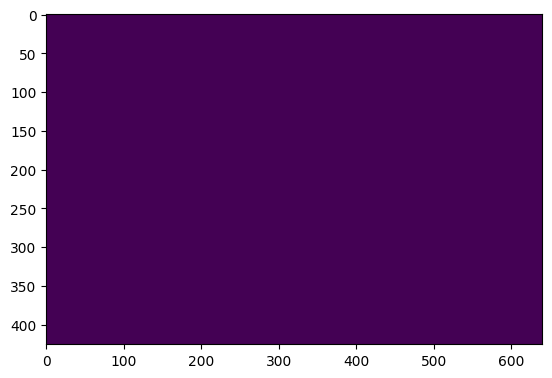

In [42]:
plt.imshow(test_image_mask)

In [43]:
mask, label = inference_one_image(test_image, model)
print(1 if label > 0.5 else 0)

0
